# Task 1.1: Prediction with RNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.load_data import get_data, load_daily_consumptions
from src.train import FederatedLearning
from src.config import Config, load_train_config

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import torch
torch.manual_seed(101)

## Specify parameters

### Manually set config

In [106]:
kwargs = {
    # Main mode
    "mode": "prediction",

    # Model config
    "model": "RNN",  # LSTM or RNN
    "hidden_dim": 32,
    "num_layers": 1,
    "dropout": 0.0,

    # Training config
    "epochs": 1000,
    "lr": 3e-4,
    "batch_size": 128
}

config = Config(**kwargs)

In [116]:
# Save config
# config.save("default_pred_rnn")

### Load saved config

In [117]:
config = load_train_config("config_default_pred_rnn")
print(config)

Config loaded from: config/config_default_pred_rnn.json
CONFIG:
  mode: prediction
  test_size: 0.2
  val_size: 0.1
  shuffle: True
  seed: 42
  model: RNN
  input_dim: 1
  hidden_dim: 32
  output_dim: 1
  num_layers: 1
  dropout: 0.0
  epochs: 1000
  lr: 0.0003
  batch_size: 128
  eval_steps: 50


## Run FL training

In [118]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

In [119]:
fl = FederatedLearning(config)
fl.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 164.70766, val loss: 701.12341
  Epoch: 50,  train loss: 113.41909, val loss: 603.01208
  Epoch: 100,  train loss: 17.08050, val loss: 81.95858
  Epoch: 150,  train loss: 21.80692, val loss: 56.87283
  Epoch: 200,  train loss: 22.06750, val loss: 56.53050
  Epoch: 250,  train loss: 24.21432, val loss: 54.89779
  Epoch: 300,  train loss: 15.25243, val loss: 52.80688
  Epoch: 350,  train loss: 19.30472, val loss: 51.22921
  Epoch: 400,  train loss: 13.75066, val loss: 50.25252
  Epoch: 450,  train loss: 18.92012, val loss: 49.68515
  Epoch: 500,  train loss: 13.10091, val loss: 49.35101
  Epoch: 550,  train loss: 13.05449, val loss: 49.20359
  Epoch: 600,  train loss: 16.33558, val loss: 49.02026
  Epoch: 650,  train loss: 19.59855, val loss: 48.84077
  Epoch: 700,  train loss: 16.30083, val loss: 48.72545
  Epoch: 750,  train loss: 14.84241, val loss: 48.64577
  Epoch: 800,  train loss: 20.17358, val loss: 48.58060
  Epoch: 850,  train loss: 14.28469, val

### Analysis

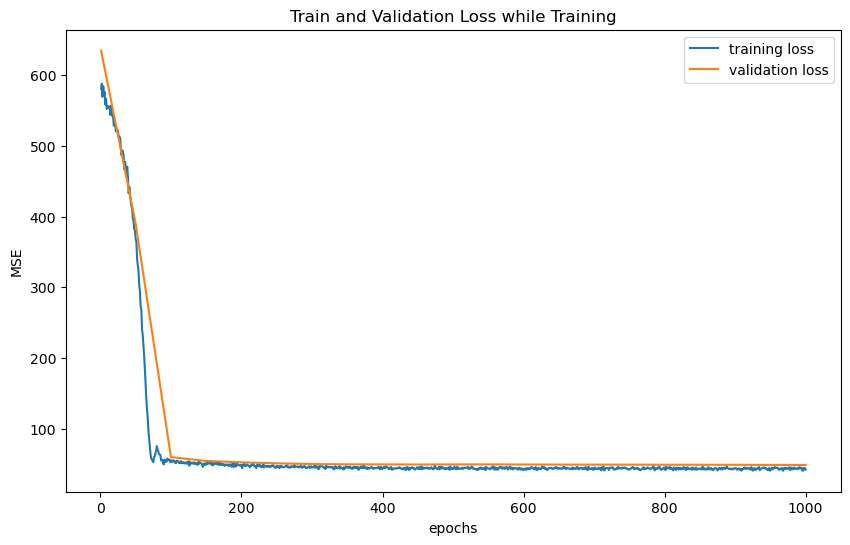

In [109]:
fl.plot_training_loss()

In [110]:
# TODO add "simulation plot": "show the predicted output vs. ground truth during the model training and testing"
daily_cons = load_daily_consumptions()
daily_cons = torch.from_numpy(daily_cons).float()
daily_cons.shape

torch.Size([50, 366])

In [111]:
with torch.no_grad():
  ground_truths, predictions = [], []
  windows = []
  for i in range(7, daily_cons.shape[1] - 1):
    window = daily_cons[0][i-7:i]
    #windows.append(torch.from_numpy(window))
    #windows = torch.stack(window)
    #predictions = fl.model(windows)
    ground_truth = daily_cons[0][i]
    y_pred = fl.model(window[None,:]).item()
    ground_truths.append([i, ground_truth.item()])
    predictions.append([i, y_pred])
  ground_truths, predictions = torch.tensor(ground_truths), torch.tensor(predictions)
ground_truths.shape, predictions.shape

(torch.Size([358, 2]), torch.Size([358, 2]))

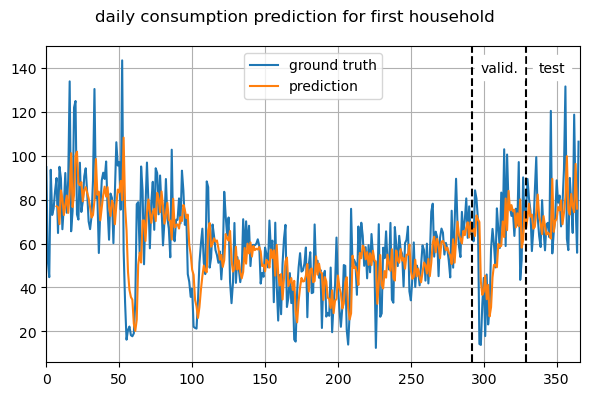

In [112]:
plt.figure(figsize=(6,4))
plt.xlim(0, daily_cons.shape[1])
plt.grid(True)
plt.suptitle("daily consumption prediction for first household")

# print ground truth and prediction
plt.plot(daily_cons[0], label="ground truth")
plt.plot(predictions[:,0], predictions[:,1], label="prediction")

# print markers for train/valid/test split
plt.axvline(daily_cons.shape[1] * 80 // 100, c="k", linestyle="--")
plt.text(daily_cons.shape[1] * 85 // 100, 140, "valid.", ha="center", va="center").set_bbox(dict(facecolor="w", edgecolor="w"))
plt.axvline(daily_cons.shape[1] * 90 // 100, c="k", linestyle="--")
plt.text(daily_cons.shape[1] * 95 // 100, 140, "test", ha="center", va="center").set_bbox(dict(facecolor="w", edgecolor="w"))

plt.legend()
plt.tight_layout();

METRICS:
  Test MSE: 48.529842376708984


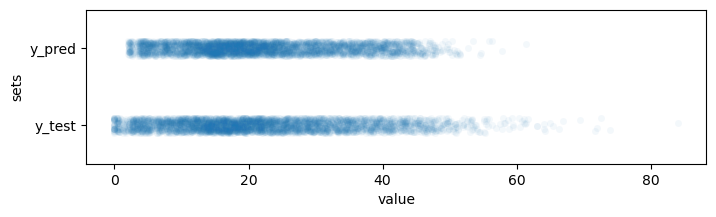

In [114]:
y_pred = fl.evaluation_metrics(x_test, y_test)
plt.figure(figsize=(8,2))
sns.stripplot(
  pd.DataFrame({"y_pred": y_pred.numpy()[:,0], "y_test": y_test.numpy().reshape(-1)}).melt(var_name="sets"),
  x="value", y="sets", alpha=.05,
);

## Run training with aggregated data

In [120]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(config)

# Stack data to aggregate all households to one
x_train, x_val, x_test = [arr.reshape(1, arr.shape[0] * arr.shape[1], arr.shape[2]) for arr in [x_train, x_val, x_test]]
y_train, y_val, y_test = [arr.reshape(1, arr.shape[0] * arr.shape[1]) for arr in [y_train, y_val, y_test]]

In [121]:
fl_agg = FederatedLearning(config)
fl_agg.train(x_train, y_train, x_val, y_val)

TRAIN:
  Epoch: 1,  train loss: 542.28418, val loss: 689.37494
  Epoch: 50,  train loss: 525.95386, val loss: 599.96033
  Epoch: 100,  train loss: 262.19778, val loss: 328.18863
  Epoch: 150,  train loss: 61.42033, val loss: 55.74060
  Epoch: 200,  train loss: 40.50719, val loss: 52.17077
  Epoch: 250,  train loss: 49.32620, val loss: 51.90658
  Epoch: 300,  train loss: 51.34007, val loss: 51.60165
  Epoch: 350,  train loss: 52.69045, val loss: 50.97123
  Epoch: 400,  train loss: 34.32603, val loss: 51.05759
  Epoch: 450,  train loss: 50.27669, val loss: 50.67018
  Epoch: 500,  train loss: 43.07464, val loss: 50.11320
  Epoch: 550,  train loss: 48.66191, val loss: 49.49681
  Epoch: 600,  train loss: 50.86912, val loss: 49.30159
  Epoch: 650,  train loss: 33.12731, val loss: 49.13408
  Epoch: 700,  train loss: 55.77694, val loss: 48.80036
  Epoch: 750,  train loss: 42.89717, val loss: 48.55468
  Epoch: 800,  train loss: 38.93744, val loss: 48.59958
  Epoch: 850,  train loss: 42.59129, v

### Analysis

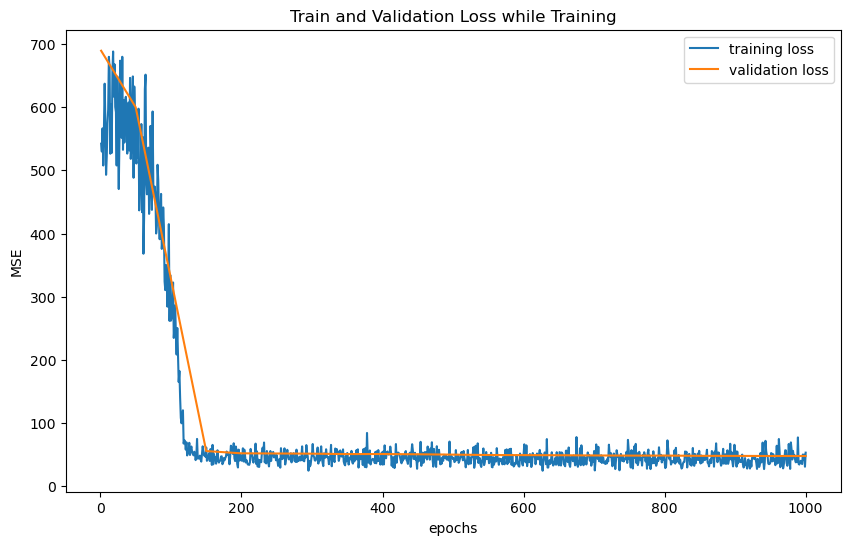

In [122]:
fl_agg.plot_training_loss()

In [124]:
y_pred = fl_agg.evaluation_metrics(x_test, y_test)

METRICS:
  Test MSE: 50.044471740722656
